# Data Extraction and Preprocessing Functions

Prior to any exploratory data analysis (EDA) or machine learning (ML), it is necessary to extract the dataset and occasionally perform initial preprocessing. 

Several functions have been created, each with different objectives, including extraction, data reduction/filtering, normalisation, day creation, etc.  

These have been designed so that they can be run in any order with the option to export to csv at various stages.

## Libraries

In [1]:
# import libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Extraction from folder to dataframe

The `Depresjon` dataset is available from https://datasets.simula.no/depresjon/ as a [zip file](https://datasets.simula.no/downloads/depresjon.zip).

The zip file contains
* `condition` folder - individual csv files for depressed individuals
* `control` folder - individual csv files for control csv files
* `scores.csv` - MADRS scores and biodemographic data

The `extract_folder` function extracts individual csv files into a pandas dataframe.  

Optional arguments:
* downsample
* save to csv


In [54]:

def extract_from_folder(folderpath, downsample=None, save_to_csv=False, output_csv_path=None):
    """
    Extract CSV data from folder and subfolders into a dataframe.

    Args:
      folderpath (str): folder containing CSV files.
      downsample (int, optional): number of rows to downsample CSVs to. Defaults to None.
      save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
      output_csv_path (str, optional): csv filepath. required if save_to_csv is True.

    Returns:
      pandas.DataFrame: DataFrame of concatenated CSV data.
    """
    import os
    import pandas as pd
    
    # dict to store dataframes by condition  
    dfs = {'control': [], 'condition': []}

    try:
        # subfolders
        subfolders = [f for f in os.listdir(folderpath) if os.path.isdir(os.path.join(folderpath, f))]

        for subfolder in subfolders:
            subfolderpath = os.path.join(folderpath, subfolder)  

            # list of CSV files
            files = os.listdir(subfolderpath)

            for file in files:
                filepath = os.path.join(subfolderpath, file)

                # extract ID from filename 
                id = file.split('.')[0]

                df = pd.read_csv(filepath)

                # optional downsample 
                if downsample:
                    df = df.sample(downsample)

                # ID column - this is the filename without the extension
                df['id'] = id

                # 'condition' column
                df['condition'] = subfolder

                # convert 'timestamp' and 'date' to datetime
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df['date'] = pd.to_datetime(df['date'])

                # append to dict by condition
                if subfolder == 'control':
                    dfs['control'].append(df)
                else:  
                    dfs['condition'].append(df)

    except OSError:
        print(f"Error reading folder: {folderpath}")

    # concatenate dfs for each condition
    dfs['control'] = pd.concat(dfs['control'])
    dfs['condition'] = pd.concat(dfs['condition'])

    # reset index on the final df
    df = pd.concat([dfs['control'], dfs['condition']]).reset_index(drop=True)

    # add label column
    df['label'] = 0
    df.loc[df['condition'] == 'condition', 'label'] = 1
    
    # remove old 'condition' column
    df.drop('condition', axis=1, inplace=True)


    try:
        if save_to_csv:
            if output_csv_path:
                df.to_csv(output_csv_path, index=False)
                print(f"df saved to {output_csv_path}")
            else:
                print("Error: Please provide an output CSV path.")
        
        
        return df
    except OSError:
        print("Error saving to CSV.")


Example use of `extract_folder` function:

In [3]:
folderpath = '../data/depresjon'
output_csv_path = '../data/petter/downsample1000K.csv'

# example downsample and store csv
df_1000K = extract_from_folder(folderpath, downsample=1000, save_to_csv=True, output_csv_path=output_csv_path)
# free memory
del df_1000K


df saved to ../data/petter/downsample1000K.csv


In [55]:

# full ds, no csv
df = extract_from_folder(folderpath)

## Add 'scores' data to df

The `scores.csv` file contains MADRS depression scores as well as additional biodemographic details such as age, education, marriage status, employment, etc. Most of the data is not available for the `control` group.

The `add_scores` function merges the `scores.csv` with a dataframe.  

Optional arguments: 
* columns to merge on
* save to csv
* limit output to 'condition' only rows


In [4]:
def add_scores(df, scores_df, merge_on_df='id', merge_on_scores='number', save_to_csv=False, output_csv_path=None, include_all_labels=True):
    """
    Adds scores data.

    Args:
        df (pd.DataFrame): extracted df.
        scores_df (pd.DataFrame):  scores df
        merge_on_df (str, optional): col in extracted df to merge on. defaults to 'id'.
        merge_on_scores (str, optional): col in scores df to merge on. defaults to 'number'.
        save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
        output_csv_path (str, optional): csv filepath. required if save_to_csv is True.
        include_all_labels (bool, optional): include all labels. defaults to True. set to False to filter only label=1.

    Returns:
        pd.DataFrame: updated df with scores added.
    """

    import pandas as pd
    try:
        # merge based on specified columns
        merged_df = pd.merge(df, scores_df, left_on=merge_on_df, right_on=merge_on_scores, how='left')
        # Fill missing values with NaN
        merged_df.fillna(value=pd.NA, inplace=True)

        # filter rows based on label
        if 'label' in merged_df.columns:
            if not include_all_labels:
                merged_df = merged_df[merged_df['label'] == 1]

        if save_to_csv:
            if output_csv_path:
                merged_df.to_csv(output_csv_path, index=False)
                print(f"Updated df saved to {output_csv_path}")
            else:
                print("Error: Please provide an output CSV path.")
        return merged_df
    except KeyError:
        print(f"Error: '{merge_on_df}' column not found in the specified DataFrames.")
        return merged_df


Example use of `add_scores` function: 

In [5]:
scores_df = pd.read_csv('../data/depresjon/scores.csv')

# add scores to downsampled df and save csv for all respondents
df_1000K_scores = add_scores(df, scores_df, save_to_csv=True, output_csv_path='../data/petter/downsample1000K_condition_with_scores.csv', include_all_labels=False)

# add scores to full df, no csv
df_scores = add_scores(df, scores_df)

# free memory
#del df_1000K_scores
#del df_scores



Updated df saved to ../data/petter/downsample1000K_condition_with_scores.csv


In [97]:
# print head where label == 0
print(df_scores[df_scores['label'] == 0].head())
# print head where label == 1
print(df_scores[df_scores['label'] == 1].head())
#print(df_scores.head())


            timestamp       date  activity         id  label     number  days  \
0 2003-03-18 15:00:00 2003-03-18        60  control_1      0  control_1     8   
1 2003-03-18 15:01:00 2003-03-18         0  control_1      0  control_1     8   
2 2003-03-18 15:02:00 2003-03-18       264  control_1      0  control_1     8   
3 2003-03-18 15:03:00 2003-03-18       662  control_1      0  control_1     8   
4 2003-03-18 15:04:00 2003-03-18       293  control_1      0  control_1     8   

   gender    age  afftype  melanch  inpatient   edu  marriage  work  madrs1  \
0       2  25-29      NaN      NaN        NaN  <NA>       NaN   NaN     NaN   
1       2  25-29      NaN      NaN        NaN  <NA>       NaN   NaN     NaN   
2       2  25-29      NaN      NaN        NaN  <NA>       NaN   NaN     NaN   
3       2  25-29      NaN      NaN        NaN  <NA>       NaN   NaN     NaN   
4       2  25-29      NaN      NaN        NaN  <NA>       NaN   NaN     NaN   

   madrs2  
0     NaN  
1     NaN  
2 

## Preprocess to Full Days

The function `extract_from_folder` extracts all files into a Pandas dataframe.  However, some days for some respondents are 'incomplete' in that there are not 1440 rows (1440 minutes in 24 days).  For some ML models, it is necessary to have a consistent number of rows per timeframe. 

The `preprocess_full_days` function extracts all complete days, i.e. where there are 1440 rows of minute data for each date from `00:00:00` to `23:59:00`.

Optional arguments: 

* option to save csv
* option to print info about resulting df
* option to suppress printing information

In [6]:
# copy df 
tobe_full = df.copy()
#print(tobe_full.info())

In [28]:
def preprocess_full_days(df, save_to_csv=False, output_csv_path=None, print_info=True):
    """
    Extracts full days from a dataframe.

    Args::
    df (DataFrame): input df.
    save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
    output_csv_path (str, optional): csv filepath. required if save_to_csv is True.
    print_info (bool, optional): print info about the df. defaults to True.

    Returns:
    DataFrame: df containing only full days (1440 rows per day).

    """
    

    # group by id and date, count rows, and filter where count equals 1440
    full_days_df = df.groupby(['id', 'date']).filter(lambda x: len(x) == 1440)

    # set index to timestamp
    full_days_df.set_index(['timestamp'], inplace=True)
    
    if print_info:
        # print id and date combinations that don't have 1440 rows
        not_full_days = df.groupby(['id', 'date']).size().reset_index(name='count').query('count != 1440')
        print("\nid and date combinations that don't have 1440 rows and have been removed:\n")
        print(not_full_days)

        # print info
        print("\nfull_days_df info:\n")
        print(full_days_df.info())

        #print full days per id
        print("\nfull days per id:\n")
        print(full_days_df.groupby('id').size()/1440)

        # print min number of days
        print("\nmin number of days per id:\n")
        print(full_days_df.groupby('id').size().min()/1440)
        

    try:
        if save_to_csv:
            if output_csv_path:
                full_days_df.to_csv(output_csv_path, index=False)
                print(f"df saved to {output_csv_path}")
            else:
                print("Error: Please provide an output CSV path.")
        
        
        return full_days_df
    except OSError:
        print("Error saving to CSV.")

    return full_days_df



Example use of `preprocess_full_days`:

In [8]:
full_days_df = preprocess_full_days(tobe_full, print_info=True)


id and date combinations that don't have 1440 rows and have been removed:

                id       date  count
0      condition_1 2003-05-07    720
16     condition_1 2003-05-23    924
17    condition_10 2004-08-31    900
32    condition_10 2004-09-15    495
33    condition_11 2004-09-28    870
...            ...        ...    ...
1101     control_7 2003-04-23    610
1102     control_8 2003-11-04    900
1122     control_8 2003-11-24    658
1123     control_9 2003-11-11    900
1143     control_9 2003-12-01    778

[115 rows x 3 columns]

full_days_df info:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1481760 entries, 2003-03-19 00:00:00 to 2004-06-09 23:59:00
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   date      1481760 non-null  datetime64[ns]
 1   activity  1481760 non-null  int64         
 2   id        1481760 non-null  object        
 3   label     1481760 non-null  int64         
dt

### Preprocess to Full Days with Start Time

The function `preprocess_full_days` extracted 24 hours worth of data for each date.  This function (`preprocess_full_days_by_start_time`)  creates '24 hour days' based on a 'start time.' For example, if specifying `06:00:00` then Day 1 will run from `06:00:00` to `05:59:00` the following day.  It will inevitably result in fewer days that `extract_full_days`.

Optional arguments:

* start_time - defaults to `00:00`
* option to save csv

In [10]:
tobe_full = df.copy()
#print(tobe_full.info())

In [11]:


def preprocess_full_days_by_start_time(df, start_time='00:00', save_to_csv=False, output_csv_path=None):
    """
    Create numbered 'days' based on the specified start time for each ID.

    Args:
        df (pd.DataFrame): df containing timestamp, id, and other relevant columns.
        start_time (str): start time in 'HH:MM' format (e.g., '06:00').
        save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
        output_csv_path (str, optional): csv filepath. required if save_to_csv is True.
    

    Returns:
        pd.DataFrame: Modified DataFrame with renumbered 'day' column.
    """
    import pandas as pd
    
    # start_time to datetime
    start_datetime = pd.to_datetime(f'1999-01-01 {start_time}:00')

    # day numbers based on start time
    df['day'] = ((df['timestamp'] - start_datetime) // pd.Timedelta(days=1)) + 1

    # filter rows to ensure each day has exactly 1440 rows
    df_filtered = df.groupby(['id', 'day']).filter(lambda x: len(x) == 1440)

    # minimum day for each ID
    min_day_per_id = df_filtered.groupby('id')['day'].min()

    # new column 'renumbered_day'
    df_filtered['renumbered_day'] = df_filtered['day'] - df_filtered['id'].map(min_day_per_id) + 1

    #  drop 'day' column
    df_filtered.drop(columns=['day'], inplace=True)
   
    print(f"New df with 'days' created based on start time: {start_time}")

    try:
        if save_to_csv:
            if output_csv_path:
                df_filtered.to_csv(output_csv_path, index=False)
                print(f"df saved to {output_csv_path}")
            else:
                print("Error: Please provide an output CSV path.")
        
        
        return df_filtered
    except OSError:
        print("Error saving to CSV.")

    return df_filtered


Example use of `preprocess_full_days_by_start_time`:

In [13]:
# specify start time
start_time_input = '06:00'
# start time df
full_days_0600 = preprocess_full_days_by_start_time(tobe_full, start_time_input)


New df with 'days' created based on start time: 06:00


In [14]:
print(full_days_0600.head())

              timestamp       date  activity         id  label  renumbered_day
900 2003-03-19 06:00:00 2003-03-19         0  control_1      0               1
901 2003-03-19 06:01:00 2003-03-19         0  control_1      0               1
902 2003-03-19 06:02:00 2003-03-19         0  control_1      0               1
903 2003-03-19 06:03:00 2003-03-19        83  control_1      0               1
904 2003-03-19 06:04:00 2003-03-19         0  control_1      0               1


## Preprocess by Reducing to a Number of Days

Some ML models require that each respondent has the same number of days.  

The function `reduce_days` reduces a dataframe into the specified number of days.  It defaults to the maximum possible for the dataframe (i.e. the min number of days by id).

Optional arguments:
* number of days - number of days to extract, default = max possible
* option to save csv

In [16]:
def reduce_days(df, num_days=None, save_to_csv=False, output_csv_path=None):
    """
    Extract a specified number of days per ID from the DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame containing relevant columns.
        num_days (int, optional): Number of days to extract (default: None).
        save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
        output_csv_path (str, optional): csv filepath. required if save_to_csv is True.

    Returns:
        pd.DataFrame: Modified DataFrame with the specified number of days per ID.
    """

    import pandas as pd
    # minimum number of days per ID
    min_days_per_id = df.groupby('id').size() // 1440

    if num_days is None:
        # use minimum  
        num_days = min_days_per_id.min()
    elif num_days > min_days_per_id.max():
        # return error if num_days exceeds the minimum
        return f"Max number of extractable days is {min_days_per_id.min()}"

    # filter rows to keep the specified number of days
    df_filtered = df.groupby('id').head(num_days * 1440)

    # save to CSV
    try:
        if save_to_csv:
            if output_csv_path:
                df_filtered.to_csv(output_csv_path, index=False)
                print(f"df saved to {output_csv_path}")
            else:
                print("Error: Please provide an output CSV path.")
        
        
        return df_filtered
    except OSError:
        print("Error saving to CSV.")

    return df_filtered


Example use of `reduce_days`: 

In [22]:

# Example usage:
reduced_6_days = reduce_days(full_days_0600, num_days=6)
print(reduced_6_days.head())  

# max and min number of days per id
print('\nMax days per id:', reduced_6_days.groupby('id').size().max()/1440)
print('Min days per id:', reduced_6_days.groupby('id').size().min()/1440)




              timestamp       date  activity         id  label  renumbered_day
900 2003-03-19 06:00:00 2003-03-19         0  control_1      0               1
901 2003-03-19 06:01:00 2003-03-19         0  control_1      0               1
902 2003-03-19 06:02:00 2003-03-19         0  control_1      0               1
903 2003-03-19 06:03:00 2003-03-19        83  control_1      0               1
904 2003-03-19 06:04:00 2003-03-19         0  control_1      0               1

Max days per id: 6.0
Min days per id: 6.0


## Removing days which have no Activity

The filtering and reduction functions *may* ensure that the dataframe does not contain days with zero activity for a respondent.  However, if these steps are not undertaken, the extracted data will contain zero-activity days.  

For example: 

![control_1 hourly plot](./hourly_control_1.png)

![condition_1 hourly plot](./hourly_condition_1.png)



It may be decided that days with zero activity (sum = 0) should be excluded as it may adversely affect a ML model.

The function `remove_zero_sum_activity` does this.

Optional arguments:
* save to csv
* removed rows to df

In [66]:
def remove_zero_sum_activity(df, save_to_csv=False, output_csv_path=None, removed=False):
    """
    Filters out days with zero total activity.

    Args:
        df (pd.DataFrame): df with columns 'id', 'date', and 'activity'.
        save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
        output_csv_path (str, optional): csv filepath. required if save_to_csv is True.
        removed (bool, optional): return removed rows? defaults to False.

    Returns:
        pd.DataFrame: df with non-zero total activity.
    """

    import pandas as pd

    # group by 'id' and 'date', calculate the sum of 'activity'
    df['date'] = pd.to_datetime(df['date'])
    df_sum = df.groupby(['id', 'date'])['activity'].sum()

    # filter out the days with zero total activity
    df_sum = df_sum[df_sum != 0]

    # filter the original df to only include these 'id' and 'date' combinations
    df_no_zero = df[df.set_index(['id', 'date']).index.isin(df_sum.index)].copy()

    # make 'date' a datetime object again
    df_no_zero['date'] = pd.to_datetime(df_no_zero['date'])

    # print rows if print_rows is True
    if removed:
        # create df with removed rows
        removed_rows = df[~df.set_index(['id', 'date']).index.isin(df_sum.index)].copy()
        return df_no_zero, removed_rows


    # save to CSV
    if save_to_csv:
        if output_csv_path:
            df_no_zero.to_csv(output_csv_path, index=False)
            print(f"Filtered DataFrame saved to {output_csv_path}")
        else:
            print("Please provide a valid output_csv_path to save the DataFrame.")

    return df_no_zero

Example use of `remove_zero_sum_activity` function.

There are 70 `(date, id)` combinations which have activity sum == 0 when extracting files directly from the folder. 

In [45]:
# print days per id where sum of activity is 0
print("Date, id combinations with zero activity:", len(tobe_full.groupby(['id', 'date'])['activity'].sum().loc[lambda x: x == 0]))

Date, id combinations with zero activity: 70


In [108]:
# Example usage:
filtered_df, removed = remove_zero_sum_activity(df, removed=True)

# print days per id where sum of activity is 0
print("Date, id combinations with zero activity:", len(filtered_df.groupby(['id', 'date'])['activity'].sum().loc[lambda x: x == 0]))
#print(filtered_df.info())

# print days per id in removed df
print("Date, id combinations with zero activity in removed df:", len(removed.groupby(['id', 'date'])['activity'].sum().loc[lambda x: x == 0]))

Date, id combinations with zero activity: 0
Date, id combinations with zero activity in removed df: 70


## Resampling

It is often required that the data needs to be resampled into other frequencies - for example from minute data to hourly or daily or 48-hourly.

The function `resample` allows for this.

Optional arguments:
* column to resample
* frequency

In [115]:
# filtered info
print(filtered_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1470906 entries, 0 to 1571705
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   timestamp  1470906 non-null  datetime64[ns]
 1   date       1470906 non-null  datetime64[ns]
 2   activity   1470906 non-null  int64         
 3   id         1470906 non-null  object        
 4   label      1470906 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 67.3+ MB
None


In [117]:
import pandas as pd
# resample  - mean, median, sum
def resample(df, resample_col='activity', frequency='h', save_to_csv=False, output_csv_path=None):
    """
    Resamples a df based on a given timestamp column and aggregates the resampled data.

    Args:
        df (pandas.DataFrame): input df.
        resample_col (str, optional): column to resample. defaults to 'activity'.
        frequency (str, optional): resampling frequency. defaults to 'h'.
        save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
        output_csv_path (str, optional): csv filepath. required if save_to_csv is True.


    Returns:
        pandas.DataFrame: The resampled and aggregated DataFrame.
    """
    # copy df
    df2 = df.copy()
    
    # convert 'timestamp' column to datetime type
    df2['timestamp'] = pd.to_datetime(df2['timestamp'])
    
    # convert 'timestamp' column to DatetimeIndex
    df2.set_index('timestamp', inplace=True)
    
    # resample data and calculate mean, sum, and median
    df_resampled = df2.groupby('id')[resample_col].resample(frequency).agg(['mean', 'sum', 'median'])
    
    # reset index
    df_resampled = df_resampled.reset_index()
    
    # add label column
    df_label = df2.groupby(['id', df2.index.date])['label'].first()
    
    # reset index
    df_label = df_label.reset_index()
    
    # rename columns
    df_label.columns = ['id', 'date', 'label']
    
    # convert date to datetime
    df_resampled['date'] = df_resampled['timestamp'].dt.date
    
    # merge dataframes
    df_final = pd.merge(df_resampled, df_label, on=['id', 'date'])

    # change date to datetime
    df_final['date'] = pd.to_datetime(df_final['date'])

    # save to CSV
    if save_to_csv:
        if output_csv_path:
            df_final.to_csv(output_csv_path, index=False)
            print(f"df saved to {output_csv_path}")
        else:
            print("Error: Please provide an output CSV path.")
    
    return df_final




2

Example use of `resample`:

In [124]:
# resample hourly
hour01 = resample(filtered_df, frequency='h', save_to_csv=True, output_csv_path='../data/petter/resampled_hourly.csv')
hour24 = resample(filtered_df, frequency='24h')

df saved to ../data/petter/resampled_hourly.csv


In [125]:
# print head
print(hour24.head())

            id  timestamp        mean     sum  median       date  label
0  condition_1 2003-05-07  174.144444  125384    76.0 2003-05-07      1
1  condition_1 2003-05-08  156.247222  224996    27.0 2003-05-08      1
2  condition_1 2003-05-09  124.135417  178755    14.0 2003-05-09      1
3  condition_1 2003-05-10  134.961806  194345    33.0 2003-05-10      1
4  condition_1 2003-05-11   99.439583  143193    15.0 2003-05-11      1


## Advanced filtering on activity levels

Some ids have days with `non-zero` but *suspiciously* little activity; so much so that it has to be considered whether they should be included in the models.  For example, `control_17`, `control_19` and `control_20` below have *flatlines* where very little activity is recorded. 

If this is deemed to be spurious, it could be excluded - **although this filtering should be undertaken with care as it could exclude genuine data**.

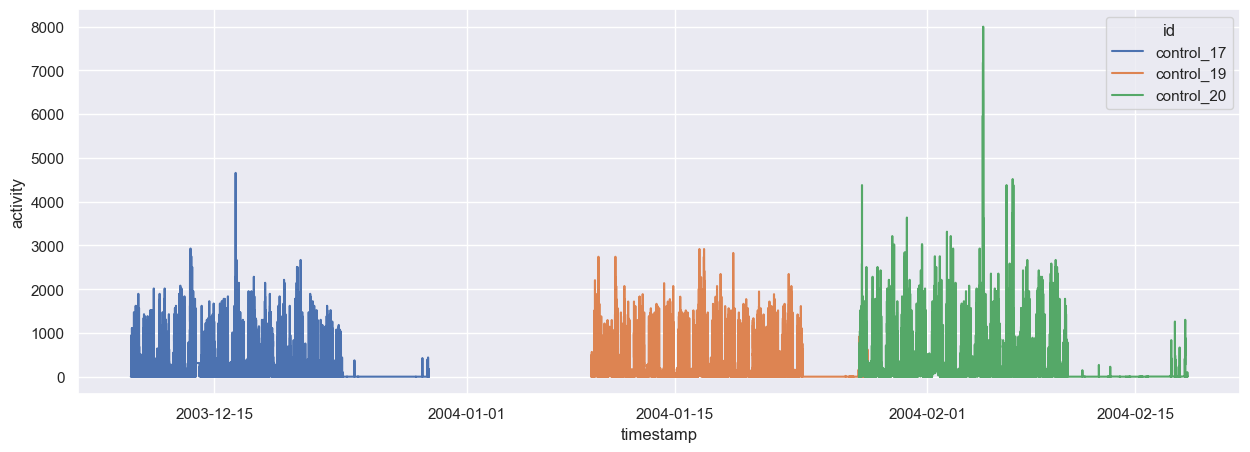

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# filter to only include control_19, control_20, and control_17
control_19_20_17 = filtered_df[filtered_df['id'].isin(['control_19', 'control_20', 'control_17'])]

# plot
sns.lineplot(data=control_19_20_17, x='timestamp', y='activity', hue='id')
plt.show()


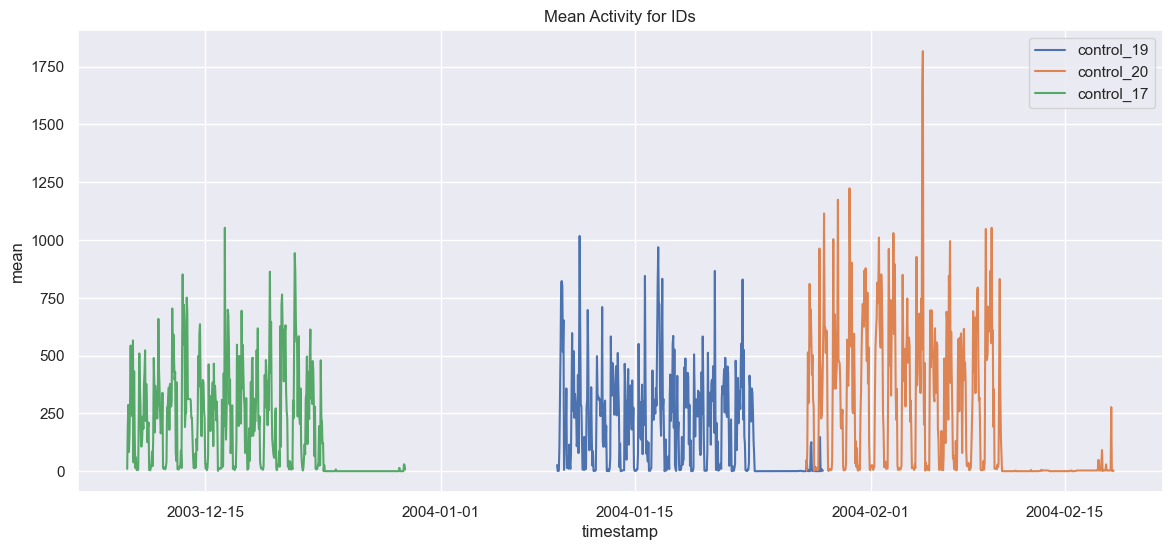

In [122]:

# plot function
def plot_activity_by_id(df, agg, id):
    plt.figure(figsize=(14, 6))
    df_id = df[df['id'] == id]
    sns.lineplot(x='timestamp', y= agg, hue='label', data=df_id)
    plt.title(f'{agg} Activity for ID: {id}')
    plt.show()

    # sample controls 
ids2 = ['control_19','control_20', 'control_17']

plt.figure(figsize=(14, 6))

for id in ids2:
    df_id = resampled_df[resampled_df['id'] == id]
    sns.lineplot(x='timestamp', y='mean', data=df_id, label=id)

plt.title('Mean Activity for IDs')
plt.legend()
plt.show()


The above plots show the 'flatline' effect - where it has to be asked if the last days of these recordings are genuine.  

* Did they leave the devices on after they were returned?
* Should they be removed?
* How?

Looking at the disbributions for daily data by label, they appear to be different.

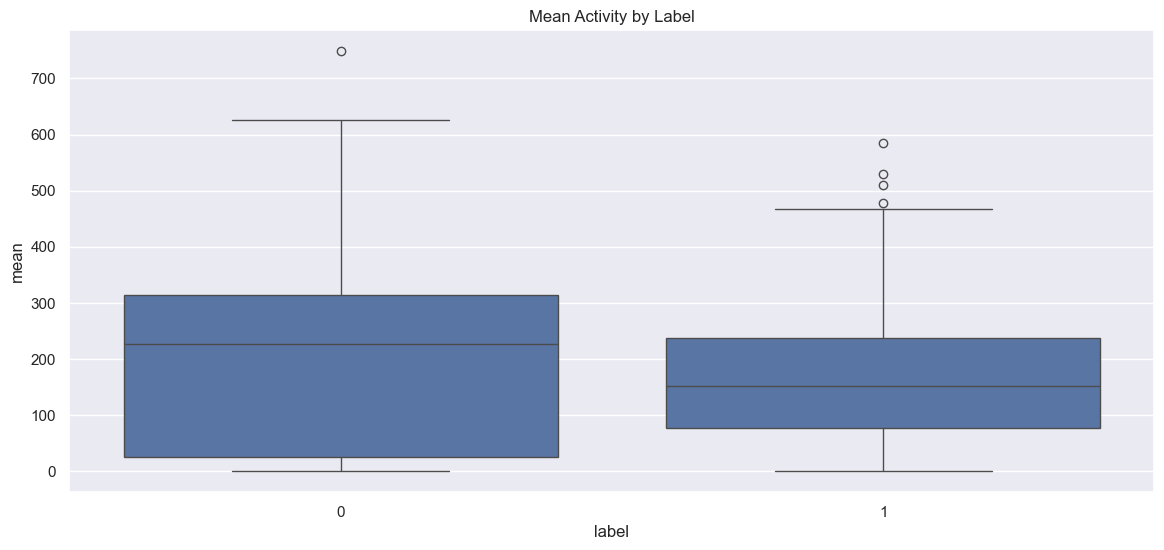

In [126]:
# boxplots of mean activity by label for resampled data
plt.figure(figsize=(14, 6))
sns.boxplot(data=hour24, x='label', y='mean')
plt.title('Mean Activity by Label')
plt.show()


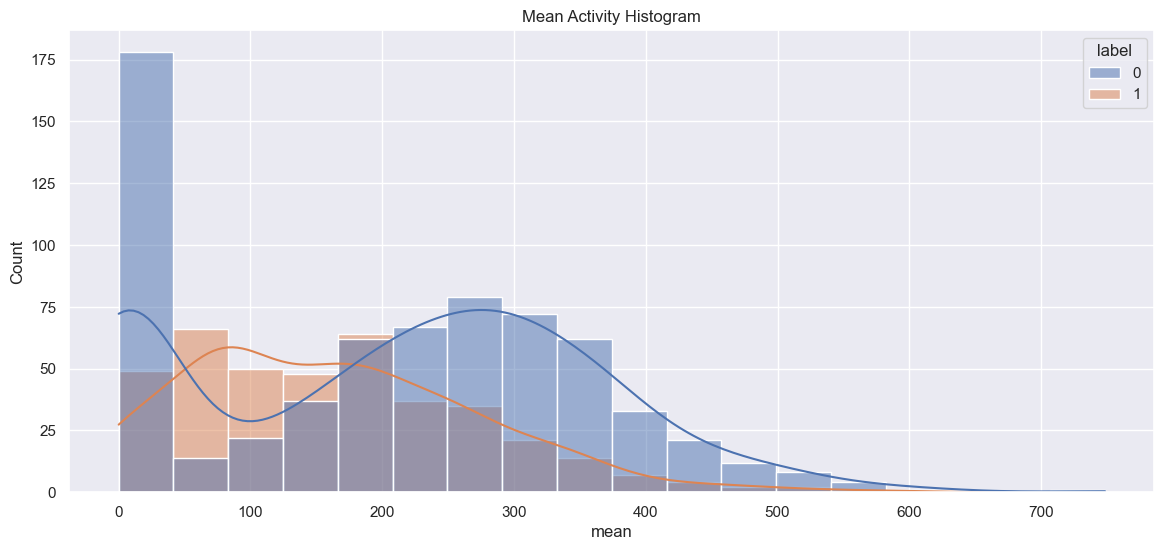

In [ ]:
# plot historgram of mean activity (hour24)
plt.figure(figsize=(14, 6))
sns.histplot(data=hour24, x='mean', hue='label', kde=True)
plt.title('Mean Activity Histogram')
plt.show()


We can check for statistically significant difference with a t-test and alpha of 0.05.

In [129]:
# statistical test to check difference in mean between groups
from scipy.stats import ttest_ind
# condition group
condition = hour24[hour24['label'] == 1]['mean']
# control group
control = hour24[hour24['label'] == 0]['mean']
# perform t-test
t_stat, p_value = ttest_ind(condition, control)
print(f't-statistic: {t_stat}, p-value: {p_value}')
# interpret the result
alpha = 0.05
if p_value > alpha:
    print('Fail to reject H0 (same distributions) at alpha = {}'.format(alpha))
else:
    print('\nReject H0 at alpha = {} and conclude different distributions'.format(alpha))



t-statistic: -4.978526140631887, p-value: 7.461421386758833e-07

Reject H0 at alpha = 0.05 and conclude different distributions


They are different, so removal of rows by a `cutoff'` or`threshold` value may need to be done by label.

How to identify the cutoff?

The example plots below clearly show a drop off in activity.

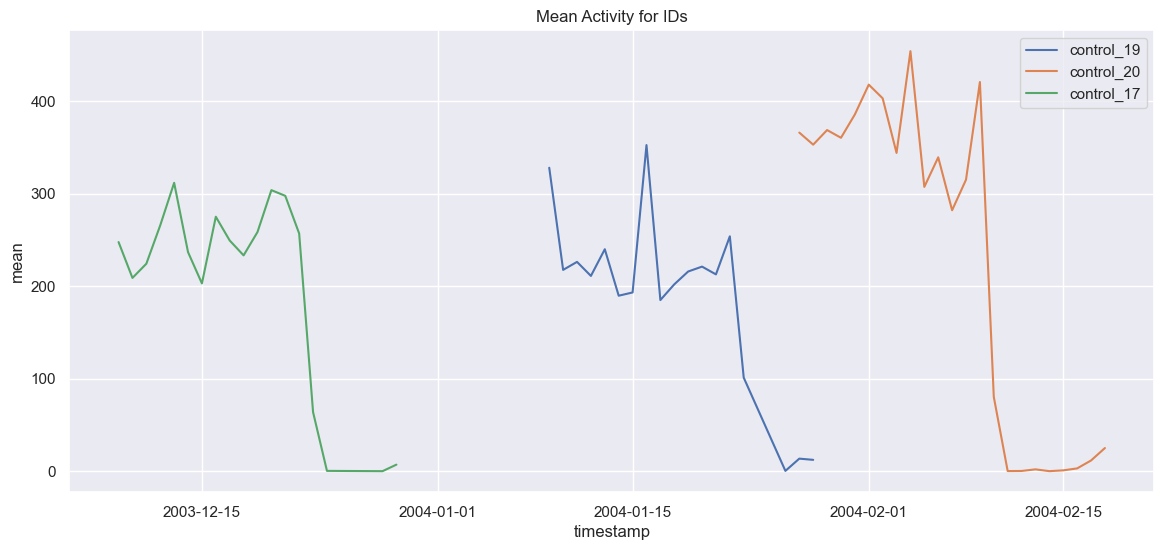

In [130]:
ids = ['condition_1', 'control_1', 'control_3', 'condition_16', 'control_17', 'condition_18', 'control_19', 'control_20']

ids2 = ['control_19','control_20', 'control_17']
plt.figure(figsize=(14, 6))

for id in ids2:
    df_id = hour24[hour24['id'] == id]
    sns.lineplot(x='timestamp', y='mean', data=df_id, label=id)

plt.title('Mean Activity for IDs')
plt.legend()
plt.show()

TODO 

function which calcluates the mean activity for an id
then the difference of a daily mean from their overall mean
use this to identify a threshold


Add normalisation function

Write up in wiki

In [137]:
# print mean activity by date 
controls = ['control_17', 'control_19', 'control_20']

# for selected 'controls'
for id in controls:
    print(hour24.query(f'id == "{id}"').groupby('date')['mean'].mean())


date
2003-12-09    247.751111
2003-12-10    208.982639
2003-12-11    224.333333
2003-12-12    265.879861
2003-12-13    311.809722
2003-12-14    236.881250
2003-12-15    203.014583
2003-12-16    275.151389
2003-12-17    249.429167
2003-12-18    233.344444
2003-12-19    258.607639
2003-12-20    303.897222
2003-12-21    297.747917
2003-12-22    256.972917
2003-12-23     63.882639
2003-12-24      0.320833
2003-12-28      0.002083
2003-12-29      7.071318
Name: mean, dtype: float64
date
2004-01-09    328.118889
2004-01-10    217.670139
2004-01-11    226.311111
2004-01-12    211.151389
2004-01-13    239.997917
2004-01-14    189.746528
2004-01-15    193.254167
2004-01-16    352.625000
2004-01-17    185.040278
2004-01-18    202.027083
2004-01-19    215.909028
2004-01-20    221.211111
2004-01-21    212.795139
2004-01-22    253.961806
2004-01-23    101.114583
2004-01-26      0.312500
2004-01-27     13.559722
2004-01-28     12.249683
Name: mean, dtype: float64
date
2004-01-27    366.128889
2004-0

In [146]:

# df with difference from mean by date for 'ids' in controls
diff_from_mean = pd.DataFrame()
# mean activity per day for control group
control_mean = hour24.query('id in @controls').groupby(['id'])['mean'].mean().reset_index()

# difference in activity from mean for controls
for id in controls:
    # add date and mean activity
    df_id = hour24.query(f'id == "{id}"')
    df_id = pd.merge(df_id, control_mean, on='id', suffixes=('', '_mean'))
    # calculate difference
    df_id['diff_from_mean'] = df_id['mean'] - df_id['mean_mean']
    # append to diff_from_mean
    diff_from_mean = pd.concat([diff_from_mean, df_id])







In [148]:
# print id, date, and difference from mean
print(diff_from_mean[['id', 'date', 'diff_from_mean']])

            id       date  diff_from_mean
0   control_17 2003-12-09       45.246663
1   control_17 2003-12-10        6.478191
2   control_17 2003-12-11       21.828885
3   control_17 2003-12-12       63.375413
4   control_17 2003-12-13      109.305274
5   control_17 2003-12-14       34.376802
6   control_17 2003-12-15        0.510135
7   control_17 2003-12-16       72.646941
8   control_17 2003-12-17       46.924718
9   control_17 2003-12-18       30.839996
10  control_17 2003-12-19       56.103191
11  control_17 2003-12-20      101.392774
12  control_17 2003-12-21       95.243468
13  control_17 2003-12-22       54.468468
14  control_17 2003-12-23     -138.621809
15  control_17 2003-12-24     -202.183615
16  control_17 2003-12-28     -202.502365
17  control_17 2003-12-29     -195.433130
0   control_19 2004-01-09      140.504663
1   control_19 2004-01-10       30.055913
2   control_19 2004-01-11       38.696885
3   control_19 2004-01-12       23.537163
4   control_19 2004-01-13       52

Looking at the mean activity level per day for three controls, there appear to be sudden drops in activiey level.

In [ ]:
conditions = ['condition_1', 'condition_16', 'condition_18', 'condition_23']

In [87]:
# print all ids, dates where sum of activity is less than 500 in descending order
print("ids, dates where sum of daily activity is less than 500:")
print(filtered_df.groupby(['id', 'date'])['activity'].agg(['mean','max','sum']).query('sum < 500').sort_values('sum', ascending=False).head())
# store in df
less_than_500 = filtered_df.groupby(['id', 'date'])['activity'].agg(['mean','max','sum']).query('sum < 500').sort_values('sum', ascending=False)

# average sum of activity per id, date
avg_sum_activity = filtered_df.groupby(['id', 'date'])['activity'].sum().groupby('id').mean()



ids, dates where sum of daily activity is less than 500:
                             mean  max  sum
id           date                          
control_17   2003-12-24  0.320833  373  462
control_19   2004-01-26  0.312500   18  450
control_31   2003-04-23  0.844794  240  430
condition_13 2005-08-27  0.265278   93  382
control_1    2003-04-11  0.258333    3  372


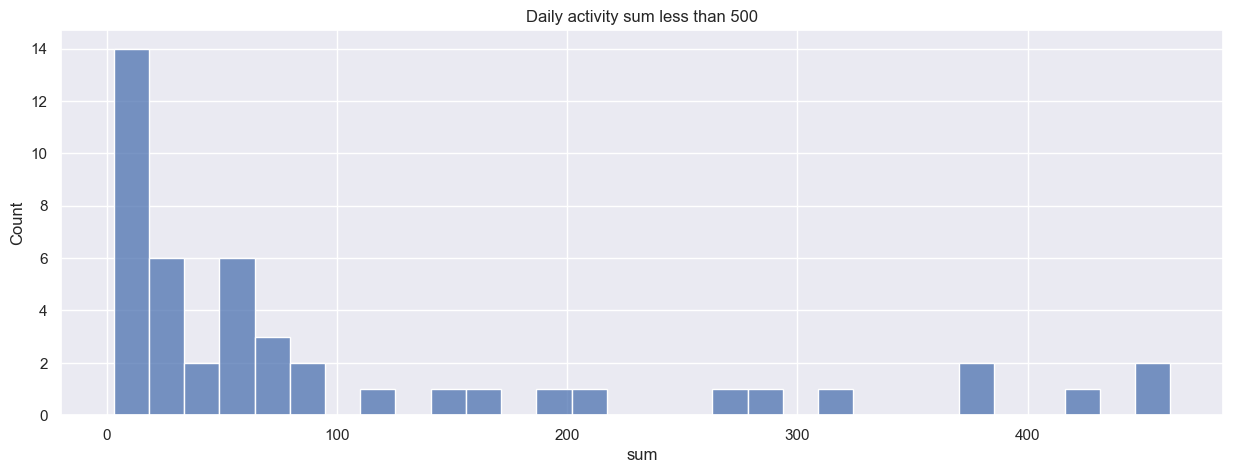

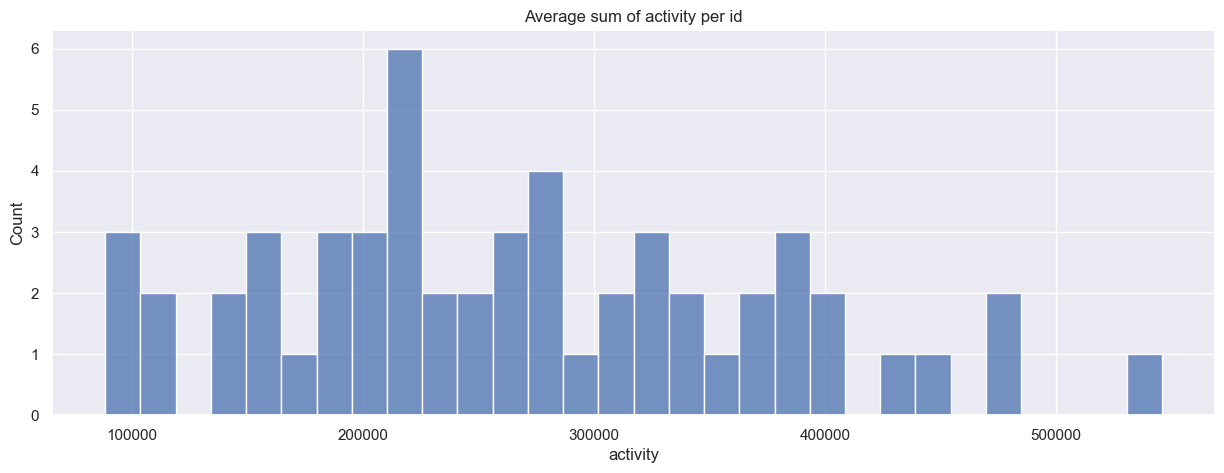

In [97]:
# plot less than sum < 500
sns.histplot(less_than_500['sum'], bins=30)
plt.title('Daily activity sum less than 500')
plt.show()

# plot average sum of activity per id
sns.histplot(avg_sum_activity, bins=30)
plt.title('Average sum of activity per id')
plt.show()



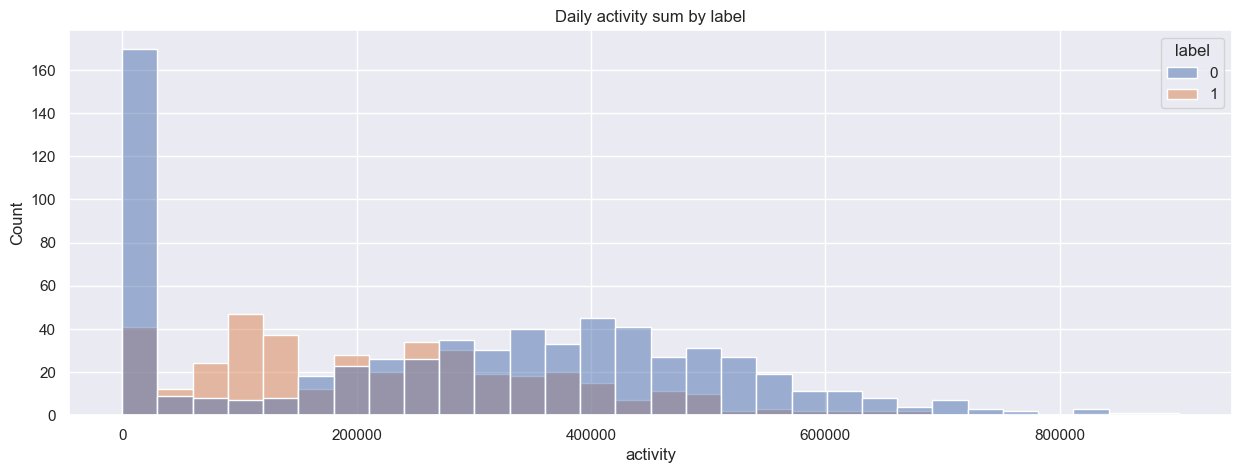

In [96]:
# sum of activity per id, date 
sum_activity = filtered_df.groupby(['id', 'date', 'label'])['activity'].sum()
# to df
sum_activity = sum_activity.reset_index()
# plot sum of activity per id, date by label
sns.histplot(data=sum_activity, x='activity', hue='label', bins=30)
plt.title('Daily activity sum by label')
plt.show()



Looking at the above plots, the argument could be made that the days very close to zero (sum) warrant further consideration.

In [ ]:


# plot sum by label
plt.figure(figsize=(14, 6))
sns.boxplot(x='label', y='mean', data=hour24)
plt.title('Mean Activity by Label')
plt.show()


Initial investigation suggests that there needs to be some tidying up before resampling:

ids, dates where min and max of activity is less than 100:
                             mean  min  max  sum
id           date                               
condition_13 2005-08-27  0.265278    0   93  382
             2005-08-28  0.201389    0   46  290
condition_16 2005-10-10  0.044444    0   58   64
             2005-10-11  0.000000    0    0    0
             2005-10-12  0.000000    0    0    0
...                           ...  ...  ...  ...
control_32   2003-04-20  0.000000    0    0    0
             2003-04-21  0.000000    0    0    0
             2003-04-22  0.000000    0    0    0
control_8    2003-11-22  0.000000    0    0    0
             2003-11-23  0.000000    0    0    0

[112 rows x 4 columns]


### Resample for tidying df 

In order to investigate, resample dataframe into: 

* hourly
* daily


In [15]:
# resample v2 - mean, median, sum
def resample2(df, resample_col, frequency):
    """
    Resamples a DataFrame based on a given timestamp column and aggregates the resampled data.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        timestamp_col (str): The name of the timestamp column in the DataFrame.
        resample_col (str): The name of the column to be resampled.
        frequency (str): The frequency at which to resample the data (e.g., 'D' for daily, 'H' for hourly).

    Returns:
        pandas.DataFrame: The resampled and aggregated DataFrame.
    """

    
    # resample data and calculate mean, sum, and median
    df_resampled = df.groupby('id')[resample_col].resample(frequency).agg(['mean', 'sum', 'median'])
    
    # reset index
    df_resampled = df_resampled.reset_index()
    
    # add label column
    df_label = df.groupby(['id', df.index.date])['label'].first()
    
    # reset index
    df_label = df_label.reset_index()
    
    # rename columns
    df_label.columns = ['id', 'date', 'label']
    
    # convert date to datetime
    df_resampled['date'] = df_resampled['timestamp'].dt.date
    
    # merge dataframes
    df_final = pd.merge(df_resampled, df_label, on=['id', 'date'])

    # change date to datetime
    df_final['date'] = pd.to_datetime(df_final['date'])
    
    return df_final


In [16]:
# resample the data into several frequencies
df = df_no_zero.copy()
hour01 = resample2(df,  'activity', 'h')
#hour02 = resample2(df,  'activity', '2h')
#hour04 = resample2(df,  'activity', '4h')
#hour06 = resample2(df,  'activity', '6h')
#hour08 = resample2(df,  'activity', '8h')
hour24 = resample2(df,  'activity', 'd')
#hour48 = resample2(df,  'activity', '2D')
#hour96 = resample2(df,  'activity', '4D')



### Remove days with (suspiciously) little activity data

Investigating by individuals where activity drops off

In [24]:
# print mean activity by date 

conditions = ['condition_1', 'condition_16', 'condition_18', 'condition_23']

controls = ['control_1', 'control_3', 'control_17', 'control_19', 'control_20']

# for selected 'conditions'
for id in conditions:
    print(hour24.query(f'id == "{id}"').groupby('date')['mean'].mean())


date
2003-05-08    156.247222
2003-05-09    124.135417
2003-05-10    134.961806
2003-05-11     99.439583
2003-05-12    316.874306
2003-05-13    108.475694
2003-05-14    155.684722
2003-05-15    170.877083
2003-05-16    190.508333
2003-05-17    177.760417
2003-05-18     97.729167
2003-05-19    168.102778
2003-05-20    111.488194
2003-05-21    199.597222
2003-05-22     71.112500
Name: mean, dtype: float64
date
2005-09-23    351.057639
2005-09-24    320.678472
2005-09-25    251.465278
2005-09-26    246.621528
2005-09-27    272.051389
2005-09-28    225.793056
2005-09-29    252.787500
2005-09-30    190.786806
2005-10-01    211.275694
2005-10-02    250.957639
2005-10-03    133.880556
2005-10-04    271.892361
2005-10-05    214.324306
2005-10-06    228.692361
2005-10-07    277.776389
2005-10-08    205.296528
2005-10-09      1.212500
2005-10-10      0.044444
2005-10-13      0.034028
2005-10-14      0.013194
2005-10-15      0.187500
2005-10-16      0.357639
2005-10-17      0.472917
2005-10-18   

In [25]:
# for selected 'controls'
for id in controls:
    print(hour24.query(f'id == "{id}"').groupby('date')['mean'].mean())

date
2003-03-19    185.568056
2003-03-20    225.981250
2003-03-21    169.663194
2003-03-22    183.690972
2003-03-23    347.075000
2003-03-24    194.423611
2003-03-25    310.715278
2003-03-26    199.518750
2003-03-27    183.131944
2003-03-28    218.872222
2003-03-29    276.368750
2003-03-31    232.002778
2003-04-01    109.022917
2003-04-02    128.501389
2003-04-03     69.356250
2003-04-04     55.559028
2003-04-07      0.134722
2003-04-08      0.059722
2003-04-09      1.460417
2003-04-10      4.538889
2003-04-11      0.258333
2003-04-12      0.022917
2003-04-16      1.336806
2003-04-17      2.412500
2003-04-18      2.295833
2003-04-19      2.168750
2003-04-20      2.110417
2003-04-21      2.460417
2003-04-22      2.376389
Name: mean, dtype: float64
date
2002-11-07    190.939583
2002-11-08    249.860417
2002-11-09    300.201389
2002-11-10    264.351389
2002-11-11    322.979861
2002-11-12    225.909028
2002-11-13    279.545139
2002-11-14    277.924306
2002-11-15    290.402083
2002-11-16   

Looking at the above samples and the summary statistics, I am going to remove full days which have approximately the following means, by label: 

* label = 0 (non-depressed) - activity mean = 100
* label = 1 (depressed) - activity mean = 50

In [26]:
import matplotlib.pyplot as plt

def plot_activity_by_dates(df, id, agg, start_date, end_date, cutoff=None):
    """
    Plot the activity for a specific ID within a given date range.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        id (str): The ID to plot the activity for.
        agg (str): The aggregation method to plot (e.g., 'mean', 'sum', 'median').
        start_date (str): The start date of the date range (format: "YYYY-MM-DD").
        end_date (str): The end date of the date range (format: "YYYY-MM-DD").
        cutoff (float, optional): The cutoff value to plot as a horizontal line. Defaults to None.
    """
    filtered_df = df.query(f'id == "{id}" and date >= "{start_date}" and date <= "{end_date}"')
    
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_df.date, filtered_df[agg])
    plt.title(f'{id} activity')
    # add horizontal line at cutoff
    if cutoff:
        plt.axhline(y=cutoff, color='r', linestyle='--')
    plt.xticks(rotation=45)
    plt.show()


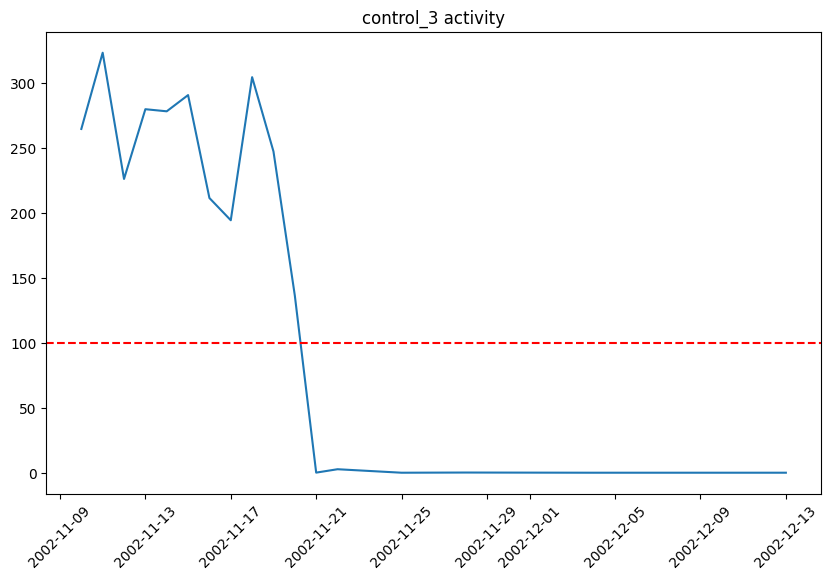

In [27]:
# plot activity for control_3
plot_activity_by_dates(hour24, 'control_3', 'mean','2002-11-10', '2002-12-14', cutoff=100)


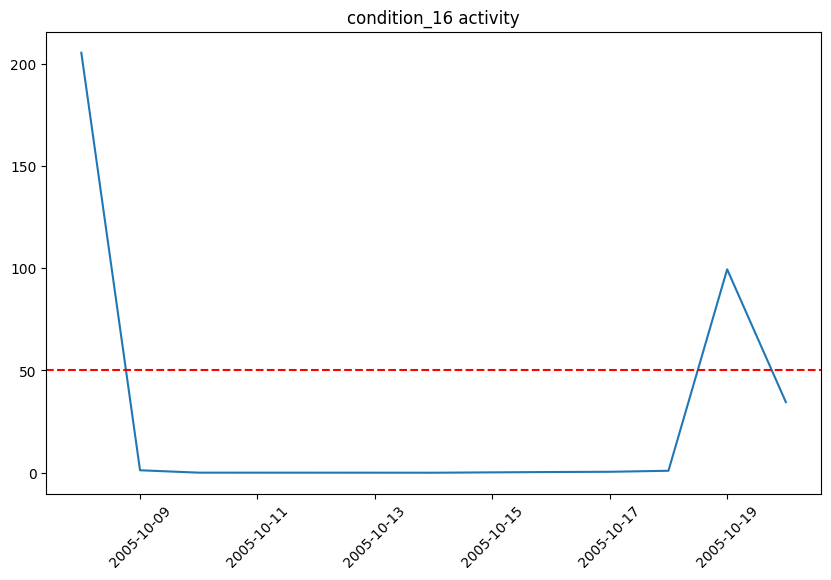

In [28]:
# plot activity for condition_16
plot_activity_by_dates(hour24, 'condition_16', 'mean','2005-10-08', '2005-10-20', cutoff=50)


#### Removal by Threshold

the 0.25 quantile is the approximate cut off.

In [29]:
# calculate 0.25 quantile of daily activity mean for each label
threshold = hour24.groupby('label')['mean'].quantile(0.25)

# sstore the thresholds separately
control_threshold = threshold[1]
condition_threshold = threshold[0]

# print the thresholds
print('Control Threshold:', control_threshold)
print('Condition Threshold:', condition_threshold)



Control Threshold: 80.92829861111112
Condition Threshold: 49.75555555555555


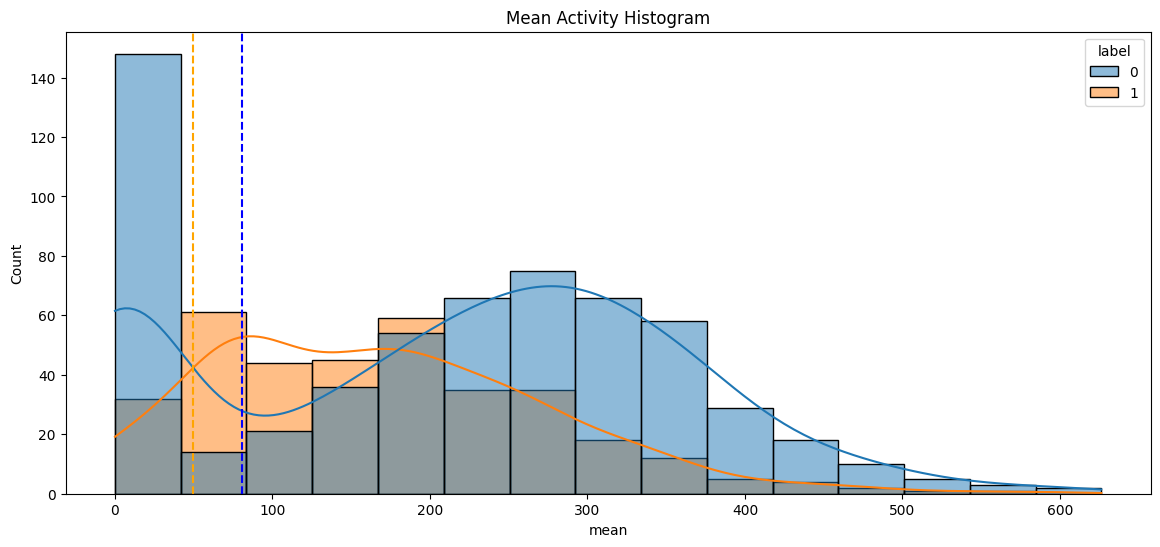

In [30]:
# plot distribution of mean activity with threshold as the cutoff for inclusion
plt.figure(figsize=(14, 6))
sns.histplot(data=hour24, x='mean', hue='label', kde=True)
plt.axvline(x=condition_threshold, color='orange', linestyle='--')
plt.axvline(x=control_threshold, color='blue', linestyle='--')
plt.title('Mean Activity Histogram')
plt.show()

In [31]:
#filter by thresholds
valid = hour24[
    (hour24['label'] == 0) & (hour24['mean'] > control_threshold) |
    (hour24['label'] == 1) & (hour24['mean'] > condition_threshold)
][['id', 'date']]

print(valid)

              id       date
0    condition_1 2003-05-08
1    condition_1 2003-05-09
2    condition_1 2003-05-10
3    condition_1 2003-05-11
4    condition_1 2003-05-12
..           ...        ...
949    control_9 2003-11-21
950    control_9 2003-11-22
951    control_9 2003-11-23
952    control_9 2003-11-24
953    control_9 2003-11-25

[765 rows x 2 columns]


In [32]:
# print number of rows being dropped
print("\nThe number of (id, date) combinations dropped: ", len(hour24) - len(valid))

# print the ids and dates dropped
print("\nIds and dates dropped: ")
dropped = hour24[~hour24.set_index(['id', 'date']).index.isin(valid.set_index(['id', 'date']).index)]
print(dropped)


The number of (id, date) combinations dropped:  194

Ids and dates dropped: 
               id  timestamp       mean    sum  median       date  label
42   condition_11 2004-10-12  37.649306  54215     0.0 2004-10-12      1
57   condition_12 2005-03-22  15.933333  22944     0.0 2005-03-22      1
73   condition_13 2005-08-27   0.265278    382     0.0 2005-08-27      1
74   condition_13 2005-08-28   0.201389    290     0.0 2005-08-28      1
94   condition_15 2005-09-05  37.477778  53968     0.0 2005-09-05      1
..            ...        ...        ...    ...     ...        ...    ...
954     control_9 2003-11-26  48.894444  70408     5.0 2003-11-26      0
955     control_9 2003-11-27   5.781250   8325     5.0 2003-11-27      0
956     control_9 2003-11-28   6.401389   9218     7.0 2003-11-28      0
957     control_9 2003-11-29   6.887500   9918     7.0 2003-11-29      0
958     control_9 2003-11-30   7.000000  10080     7.0 2003-11-30      0

[194 rows x 7 columns]


Check some samples: 

In [33]:
# print condition 16 from dropped
print("\nCondition 16 from dropped: ")
print(dropped.query('id == "condition_16"'))

# print 2005-10-19 from hour24 for condition 16
print("\n2005-10-12 from hour24 for condition 16: ")
print(hour24.query('id == "condition_16" and date == "2005-10-19"'))




Condition 16 from dropped: 
               id  timestamp       mean    sum  median       date  label
119  condition_16 2005-10-09   1.212500   1746     0.0 2005-10-09      1
120  condition_16 2005-10-10   0.044444     64     0.0 2005-10-10      1
121  condition_16 2005-10-13   0.034028     49     0.0 2005-10-13      1
122  condition_16 2005-10-14   0.013194     19     0.0 2005-10-14      1
123  condition_16 2005-10-15   0.187500    270     0.0 2005-10-15      1
124  condition_16 2005-10-16   0.357639    515     0.0 2005-10-16      1
125  condition_16 2005-10-17   0.472917    681     0.0 2005-10-17      1
126  condition_16 2005-10-18   0.967361   1393     0.0 2005-10-18      1
128  condition_16 2005-10-20  34.510417  49695     3.0 2005-10-20      1

2005-10-12 from hour24 for condition 16: 
               id  timestamp       mean     sum  median       date  label
127  condition_16 2005-10-19  99.436806  143189     3.0 2005-10-19      1


C:\Users\zoona\AppData\Local\Temp\ipykernel_14408\4270646942.py:7: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  print(hour24.query('id == "condition_16" and date == "2005-10-19"'))


In [34]:
# print control 20 from dropped
print("\nControl 20 from dropped: ")
print(dropped.query('id == "control_20"'))

# print 2005-02-10 from hour24 for control 20
print("\n2004-02-10 from hour24 for control 20: ")
print(hour24.query('id == "control_20" and date == "2004-02-10"'))


Control 20 from dropped: 
             id  timestamp       mean     sum  median       date  label
574  control_20 2004-02-10  80.325694  115669     0.0 2004-02-10      0
575  control_20 2004-02-11   0.111111     160     0.0 2004-02-11      0
576  control_20 2004-02-12   0.224306     323     0.0 2004-02-12      0
577  control_20 2004-02-13   1.967361    2833     3.0 2004-02-13      0
578  control_20 2004-02-14   0.018750      27     0.0 2004-02-14      0
579  control_20 2004-02-15   0.883333    1272     0.0 2004-02-15      0
580  control_20 2004-02-16   3.000000    4320     3.0 2004-02-16      0
581  control_20 2004-02-17  11.559028   16645     3.0 2004-02-17      0

2004-02-10 from hour24 for control 20: 
             id  timestamp       mean     sum  median       date  label
574  control_20 2004-02-10  80.325694  115669     0.0 2004-02-10      0


C:\Users\zoona\AppData\Local\Temp\ipykernel_14408\1513146520.py:7: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  print(hour24.query('id == "control_20" and date == "2004-02-10"'))


Looking at the above, some days are just above these thresholds - perhaps they should be removed? 

* to consider.

In [36]:
# new df with from df_no_zero with only valid ids and dates
df_valid = df_no_zero[df_no_zero.set_index(['id', 'date']).index.isin(valid.set_index(['id', 'date']).index)]

In [37]:
# difference in length between df_no_zero and df_valid
print("Difference in length between df_no_zero and df_valid: ", len(df_no_zero) - len(df_valid))

Difference in length between df_no_zero and df_valid:  279360


In [38]:
print(df_valid)
print(df_valid.info())

                                    date  activity           id  label
timestamp                                                             
2003-03-19 00:00:00  2003-03-19 00:00:00         0    control_1      0
2003-03-19 00:01:00  2003-03-19 00:00:00         0    control_1      0
2003-03-19 00:02:00  2003-03-19 00:00:00         0    control_1      0
2003-03-19 00:03:00  2003-03-19 00:00:00         0    control_1      0
2003-03-19 00:04:00  2003-03-19 00:00:00       175    control_1      0
...                                  ...       ...          ...    ...
2004-06-09 23:55:00  2004-06-09 00:00:00       169  condition_9      1
2004-06-09 23:56:00  2004-06-09 00:00:00       169  condition_9      1
2004-06-09 23:57:00  2004-06-09 00:00:00       169  condition_9      1
2004-06-09 23:58:00  2004-06-09 00:00:00       169  condition_9      1
2004-06-09 23:59:00  2004-06-09 00:00:00        60  condition_9      1

[1101600 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeInd

<Figure size 1400x600 with 0 Axes>

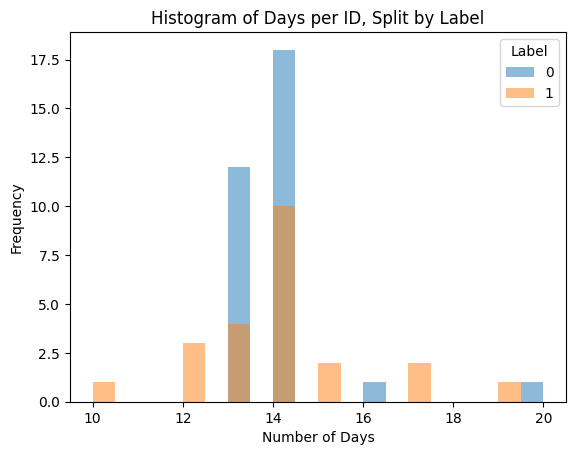

In [39]:
# count days per id in valud df
#print(df_valid.groupby('id')['date'].nunique())

# count days per id in valid df
plt.figure(figsize=(14, 6))
df_valid.groupby(['id', 'label'])['date'].nunique().unstack().plot(kind='hist', bins=20, alpha=0.5)
plt.title('Histogram of Days per ID, Split by Label')
plt.xlabel('Number of Days')
plt.ylabel('Frequency')
plt.legend(title='Label')
plt.show()



In [57]:
# save df_valid to a new csv file
df_valid.to_csv('minute01.csv', index=False)


### Resampling

In [40]:

def resample3(df, resample_col, frequency):
    """
    Resamples a DataFrame based on a given timestamp column and aggregates the resampled data.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        resample_col (str): The name of the column to be resampled.
        frequency (str): The frequency at which to resample the data (e.g., 'D' for daily, 'H' for hourly).

    Returns:
        pandas.DataFrame: The resampled and aggregated DataFrame.
    """
    # resample data and calculate mean, sum, median, std, min, max, skew, kurtosis
    df_resampled = df.groupby('id')[resample_col].resample(frequency).agg(['mean', 'sum', 'median', 'std', 'var', 'min', 'max'])
    
    # reset index
    df_resampled = df_resampled.reset_index()
    
    # add label column
    df_label = df.groupby(['id', df.index.date])['label'].first()
    
    # reset index
    df_label = df_label.reset_index()
    
    # rename columns
    df_label.columns = ['id', 'date', 'label']
    
    # convert date to datetime
    df_resampled['date'] = df_resampled['timestamp'].dt.date
    
    # merge dataframes
    df_final = pd.merge(df_resampled, df_label, on=['id', 'date'])

    # change date to datetime
    df_final['date'] = pd.to_datetime(df_final['date'])
    
    return df_final

In [41]:
# resample the data into several frequencies
df = df_valid.copy()
hour01 = resample3(df,  'activity', 'h')
hour02 = resample3(df,  'activity', '2h')
hour04 = resample3(df,  'activity', '4h')
hour06 = resample3(df,  'activity', '6h')
hour08 = resample3(df,  'activity', '8h')
hour12 = resample3(df,  'activity', '12h')
hour24 = resample3(df,  'activity', 'd')
hour48 = resample3(df,  'activity', '2D')
hour96 = resample3(df,  'activity', '4D')



#### Inspect dfs

In [42]:
# info of hour1
print(hour01.info())
# head of hour1
print(hour01.head())
# describe mean, sum, median of hour1
#print(hour01[['mean', 'sum', 'median']].describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18360 entries, 0 to 18359
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         18360 non-null  object        
 1   timestamp  18360 non-null  datetime64[ns]
 2   mean       18360 non-null  float64       
 3   sum        18360 non-null  int64         
 4   median     18360 non-null  float64       
 5   std        18360 non-null  float64       
 6   var        18360 non-null  float64       
 7   min        18360 non-null  float64       
 8   max        18360 non-null  float64       
 9   date       18360 non-null  datetime64[ns]
 10  label      18360 non-null  int64         
dtypes: datetime64[ns](2), float64(6), int64(2), object(1)
memory usage: 1.5+ MB
None
            id           timestamp       mean  sum  median        std  \
0  condition_1 2003-05-08 00:00:00   8.000000  480     0.0  42.225785   
1  condition_1 2003-05-08 01:00:00   4.083333  2

In [56]:

# extract the hour from timestamp
hour01['start_hour'] = hour01['timestamp'].dt.hour

# group by date and id, find the minimum start hour
min_start_hour = hour01.groupby(['date', 'id'])['start_hour'].min()

# most common start hour across all groups
most_common_start_hour = min_start_hour.mode().values[0]

print(f"The most common start hour is: {most_common_start_hour} hour")

# print unique start hours
unique_start_hours = min_start_hour.unique()
print(f"Unique start hours: {unique_start_hours}")



The most common start hour is: 0 hour
Unique start hours: [0]


In [43]:
# info for hour6
print(hour06.info())
# head of hour6
print(hour06.head())
# describe mean, sum, median of hour6
print(hour06[['mean', 'sum', 'median']].describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3060 entries, 0 to 3059
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         3060 non-null   object        
 1   timestamp  3060 non-null   datetime64[ns]
 2   mean       3060 non-null   float64       
 3   sum        3060 non-null   int64         
 4   median     3060 non-null   float64       
 5   std        3060 non-null   float64       
 6   var        3060 non-null   float64       
 7   min        3060 non-null   float64       
 8   max        3060 non-null   float64       
 9   date       3060 non-null   datetime64[ns]
 10  label      3060 non-null   int64         
dtypes: datetime64[ns](2), float64(6), int64(2), object(1)
memory usage: 263.1+ KB
None
            id           timestamp        mean     sum  median         std  \
0  condition_1 2003-05-08 00:00:00    6.061111    2182     0.0   28.469534   
1  condition_1 2003-05-08 06:00:00  17

#### Save to csvs



In [ ]:
# save all dataframes to csv
hour01.to_csv('hour01.csv', index=False)
hour02.to_csv('hour02.csv', index=False)
hour04.to_csv('hour04.csv', index=False)
hour06.to_csv('hour06.csv', index=False)
hour08.to_csv('hour08.csv', index=False)
hour12.to_csv('hour12.csv', index=False)
hour24.to_csv('hour24.csv', index=False)
hour48.to_csv('hour48.csv', index=False)
hour96.to_csv('hour96.csv', index=False)
